# Module 1 - Data Exploration Prototype

In [1]:
# Load the required libraries
import warnings
import zipfile
import os
import cv2
import urllib.request
import sagemaker
import numpy as np
import mxnet as mx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
warnings.simplefilter('ignore')
%matplotlib inline

## Load Training Obersavations

In [2]:
# Helper function
def download(url):
    """
    Helper function to download individual file from given url.
    
    Arguments:
    url -- full URL of the file to download
    
    Returns:
    filename -- downloaded file name
    """
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)
    return filename

# To download and extract Sample Data
URL = 'https://s3-us-west-2.amazonaws.com/sagemaker-workshop-500842391574-us-west-2/data/data.zip'
file = download(URL)

# Extract the file
with zipfile.ZipFile(file) as zf:
    zf.extractall()

## View the Data

In [3]:
# View the log data
data_df = pd.read_csv('./data/driving_log.csv')
data_df.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


## Describe the Data

In [4]:
# Data Overview
print("Dataset Shape: {}\n".format(data_df.shape))
print(data_df.describe())

Dataset Shape: (8036, 7)

          steering     throttle        brake        speed
count  8036.000000  8036.000000  8036.000000  8036.000000
mean      0.004070     0.869660     0.001970    28.169839
std       0.128840     0.301326     0.036565     6.149327
min      -0.942695     0.000000     0.000000     0.502490
25%       0.000000     0.985533     0.000000    30.183093
50%       0.000000     0.985533     0.000000    30.186400
75%       0.000000     0.985533     0.000000    30.186640
max       1.000000     0.985533     1.000000    30.709360


## Visualize the Data

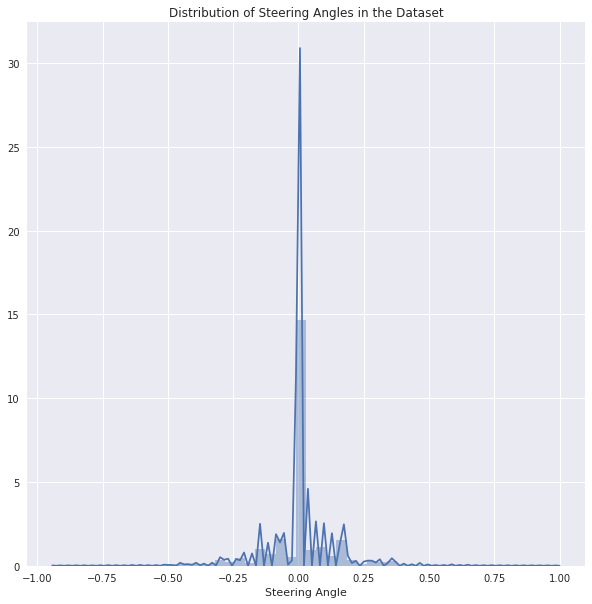

In [5]:
# Visualize the distribution of the data
# using the `seabourne` library
sns.set(rc={'figure.figsize':(10, 10)})
fig = sns.distplot(data_df.steering)
plt.xlabel("Steering Angle")
plt.title("Distribution of Steering Angles in the Dataset")
plt.show(fig);

---
# Data Preprocessing

## Feature Extraction

In [6]:
# Separate the features
X = data_df[['center', 'left', 'right']].values
y = data_df['steering'].values

## Image Transformations

In [7]:
# Image Transformation: Crop
def crop(image):
    """
    Crops the image by emoving the sky at the top and the car front at the bottom.

    Arguments:
    image -- numpy.array representing an RGB image of format (Height, Width, Channel).

    Returns:
    Cropped image.
    """
    image = image[60:-25, :, :]

    return image

In [8]:
def resize(image):
    """
    Resize the image to the input shape for the NVIDIA model.

    Arguments:
    image -- numpy array representing image.
    height -- desired image height.
    width -- desired image width.

    Returns:
    Resized image.
    """
    image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)

    return image

In [9]:
# Image Transformation: Convert from RGB to YUV
def rgb2yuv(image):
    """
    Convert the image from RGB to YUV color space.

    Arguments:
    image -- numpy array represnting the image.

    Returns:
    YUV image.
    """
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

    return image

## Image Augmentation

In [10]:
# Image Augmentation: Random Flip
def random_flip(image, steering_angle):
    """
    Randomly flip the 50% of the images from left to right and vice-versa.
    Additionally, adjust the steering angle accordingly.

    Arguments:
    image -- pre-processed input image.
    steering_amngle -- pre-processed steering angle.

    Returns:
    image -- flipped image.
    steering_angle -- adjusted steering angle.
    """
    # Randomly select 0.5 of the images
    if np.random.rand() < 0.5:
        # Apply the flip function to the vertical axis.
        image = cv2.flip(image, 1)

        # Adjust the steering angle to the reverse of the current steering angle.
        steering_angle = -steering_angle

    # Return the "flipped" image and new steering angle.

    return image, steering_angle

In [11]:
# Image Augmentation: Random Translate
def translate(image, steering_angle, x_range, y_range):
    """
    Randomly shift (translate) the image vertically and horizontally.

    Arguments:
    image -- pre-processed input image.
    steering_angle -- pre-processed steering angle.
    x_range -- x-axis pixels.
    y_range -- y-axis pixels.

    Returns:
    image -- translated image.
    steering_angle -- adjusted steeing angle.
    """
    # Randomly adjust the x and y axis
    x_transform = x_range * (np.random.rand() - 0.5)
    y_transform = y_range * (np.random.rand() - 0.5)

    # Adjust the steering angle
    steering_angle += x_transform * 0.002
    m_transform = np.float32([[1, 0, x_transform], [0, 1, y_transform]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, m_transform, (width, height))

    return image, steering_angle

# Image Augmentation: Random Distortion
def distort(image):
    """
    Add distortion to random images and adjust the brightness.

    Arguments:
    image -- pre-processed input image.

    Returns:
    new_image -- distorted image.
    """
    # Create placeholder numpy array for the new image
    new_img = image.astype(float)

    # Add random brightness
    value = np.random.randint(-28, 28)
    if value > 0:
        mask = (new_img[:, :, 0] + value) > 255
    if value <= 0:
        mask = (new_img[:, :, 0] + value) < 0
    new_img[:,:,0] += np.where(mask, 0, value)

    # Add random shadow 
    h,w = new_img.shape[0:2]
    mid = np.random.randint(0, w)
    factor = np.random.uniform(0.6, 0.8)
    if np.random.rand() > .5:
        new_img[:, 0:mid, 0] *= factor
    else:
        new_img[:, mid:w, 0] *= factor
    
    # Randomly shift the horizon
    h, w, _ = new_img.shape
    horizon = 2 * h / 5
    v_shift = np.random.randint(-h / 8, h / 8)
    pts1 = np.float32([[0, horizon], [w, horizon], [0, h], [w, h]])
    pts2 = np.float32([[0, horizon + v_shift], [w, horizon + v_shift], [0, h], [w, h]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    new_img = cv2.warpPerspective(new_img, M, (w, h), borderMode=cv2.BORDER_REPLICATE)

    return new_img.astype(np.uint8)

# Image Augmentation: Random Brightness
def brightness(image):
    """
    Randomly adjust brightness of the image.
    """
    # Convert image to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Randomly adjust the brightness ratio and apply it
    # to the image
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio

    # Convert back to RGB and return the image
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

## Image Augmentation Example

In [12]:
# Helper function
def load(data_dir, image_file):
    """
    Load RGB images from a file
    """
    return mpimg.imread(os.path.join(data_dir, image_file.strip()))

def transform(image):
    """
    Combine all preprocess functions into one
    """
    image = crop(image)
    image = resize(image)
    image = rgb2yuv(image)
    return image

### Random Sample Image

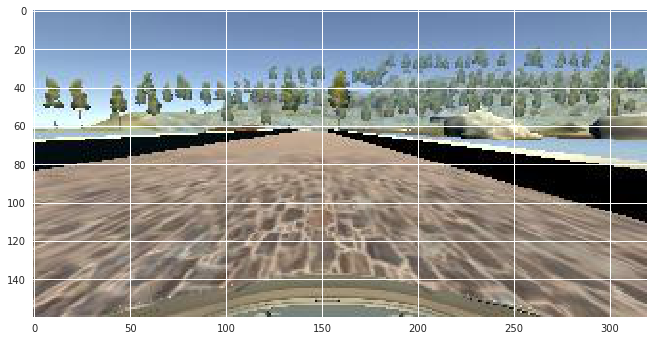

In [13]:
# Origional 'left' image
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
random_image = X[100][0]
img = load('data', random_image)
#img = ('', random_image)
plt.rcParams['figure.figsize'] = (11.0, 10.0)
plt.imshow(img);

### Plot Augmented Images

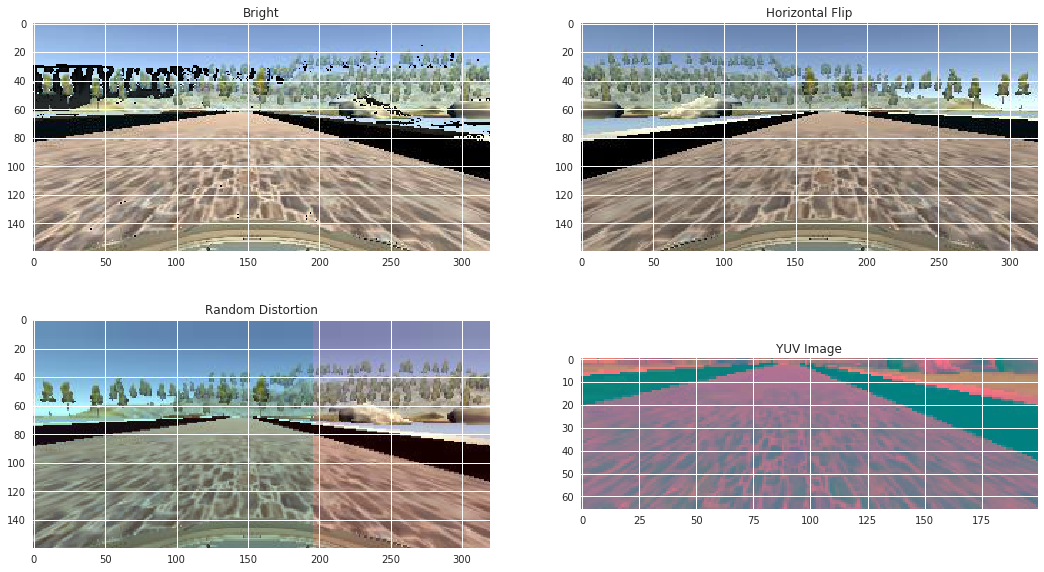

In [14]:
# Create Subpluts for Augmented Images
plt.close('all')
fig = plt.figure(figsize=(18., 10.))
sub1 = fig.add_subplot(221)
sub1.set_title('Bright')
sub1.imshow(brightness(img))
sub2 = fig.add_subplot(222)
sub2.set_title('Horizontal Flip')
sub2.imshow(cv2.flip(img, 1))
sub3 = fig.add_subplot(223)
sub3.set_title('Random Distortion')
sub3.imshow(distort(img));
sub4 = fig.add_subplot(224)
sub4.set_title('YUV Image')
sub4.imshow(transform(img));
plt.show()

## Image Augmentation Pipeline...

In [15]:
# Batch Image Configurations
HEIGHT, WIDTH, CHANNELS = 66, 200, 3
INPUT_SHAPE = (HEIGHT, WIDTH, CHANNELS)

# Aumentation Pipeline Functions
def choose(data_dir, center, left, right, steering_angle):
    """
    Randomly choose an image from the center, left or right, and adjust
    the steering angle.
    """
    choice = np.random.choice(3)
    if choice == 0:
        return load(data_dir, left), steering_angle + 0.2
    elif choice == 1:
        return load(data_dir, right), steering_angle - 0.2
    return load(data_dir, center), steering_angle

def augment(data_dir, center, left, right, steering_angle, range_x=100, range_y=10):
    """
    Generate an augumented image and adjust steering angle.
    (The steering angle is associated with the center image)
    """
    image, steering_angle = choose(data_dir, center, left, right, steering_angle)
    image, steering_angle = random_flip(image, steering_angle)
    image, steering_angle = translate(image, steering_angle, range_x, range_y)
    image = brightness(image)
    image = distort(image)
    return image, steering_angle


def aug_pipeline(data_dir, image_paths, steering_angles, size, is_training):
    """
    #Generate training image give image paths and associated steering angles
    """
    images = np.empty([size, HEIGHT, WIDTH, CHANNELS])
    steering = np.empty(size)
    while True:
        i = 0
        for index in np.random.permutation(image_paths.shape[0]):
            center, left, right = image_paths[index]
            steering_angle = steering_angles[index]
            # argumentation
            if is_training and np.random.rand() < 1.:
                image, steering_angle = augment(data_dir, center, left, right, steering_angle)
            else:
                image = load(data_dir, center) 
            # add the image and steering angle to the batch
            images[i] = transform(image)
            steering[i] = steering_angle
            i += 1
            if i == size:
                break
        return np.array(images).astype(np.float32), np.array(steering).astype(np.float32)


Use the Augmentation Pipeline functions to create the Training and Vlaidation Datasets using a 90/10 split respectivley. There is no Test Dataset as the final test will be acomplished using the Simulator.

In [16]:
X_sample, y_sample = aug_pipeline('data', X, y, len(X),True)

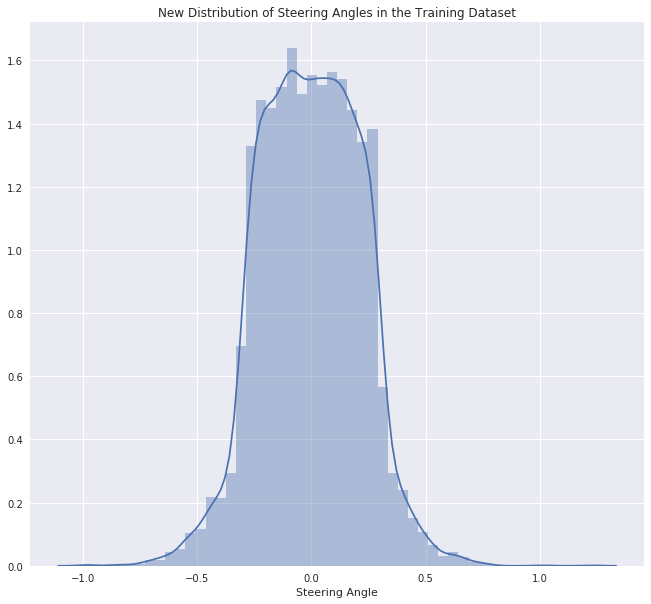

In [17]:
# Plot New Distribution of training examples
fig = sns.distplot(y_sample)
plt.xlabel("Steering Angle")
plt.title("New Distribution of Steering Angles in the Training Dataset")
plt.show(fig);

---
# Prepare the Training/Validation Datsets


In [18]:
# Libraries and SageMaker configuration
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# Create Training and Validation datasets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [19]:
# Preprocess through the pipline
X_train, y_train = aug_pipeline('data', X_train, y_train, len(X_train), True)
X_valid, y_valid = aug_pipeline('data', X_valid, y_valid, len(X_valid), False)

In [20]:
# View resultant shape
print("Training Dataset Shape: {}\n".format(X_train.shape))
print("Validation Dataset Shape: {}".format(X_valid.shape))

Training Dataset Shape: (7232, 66, 200, 3)

Validation Dataset Shape: (804, 66, 200, 3)


In [21]:
# Create local repository for Numpy Arrays
if not os.path.exists('/tmp/data'):
    os.mkdir('/tmp/data')

# Save the Dataset as Numpy Arrays
np.save('/tmp/data/train_X.npy', X_train)
np.save('/tmp/data/train_Y.npy', y_train)
np.save('/tmp/data/valid_X.npy', X_valid)
np.save('/tmp/data/valid_Y.npy', y_valid)

---
# Next Step: Build and Train the model in SageMaker
[Module 2](../2_SageMakerBYOM/README.md)